<a href="https://colab.research.google.com/github/ivan-mihailov/LS-Unit-2-Portfolio-Project/blob/main/Final_Drought_Prediction_Portfolio_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Ingestion and Initial EDA

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
!kaggle datasets download -d cdminix/us-drought-meteorological-data

100% 897M/901M [00:17<00:00, 64.3MB/s]
100% 901M/901M [00:17<00:00, 53.4MB/s]


In [ ]:
!unzip us-drought-meteorological-data.zip

Archive:  us-drought-meteorological-data.zip
  inflating: soil_data.csv           
  inflating: test_timeseries/test_timeseries.csv  
  inflating: train_timeseries/train_timeseries.csv  
  inflating: validation_timeseries/validation_timeseries.csv  


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [ ]:
# Ingest meteorological data from training dataset as dataframe
train = pd.read_csv('/content/train_timeseries/train_timeseries.csv')
train.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,9.50,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,10.18,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,7.41,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,13.48,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


In [ ]:
train.shape

(19300680, 21)

In [ ]:
# Determine whether there are NaNs in the data and their significance (if any)
train.isna().sum()

fips                  0
date                  0
PRECTOT               0
PS                    0
QV2M                  0
T2M                   0
T2MDEW                0
T2MWET                0
T2M_MAX               0
T2M_MIN               0
T2M_RANGE             0
TS                    0
WS10M                 0
WS10M_MAX             0
WS10M_MIN             0
WS10M_RANGE           0
WS50M                 0
WS50M_MAX             0
WS50M_MIN             0
WS50M_RANGE           0
score          16543884
dtype: int64

In [ ]:
train.describe() # Explore the training dataset

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
count,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,2.756796e+06
mean,3.067038e+04,2.644145e+00,9.665578e+01,7.816178e+00,1.280146e+01,6.951072e+00,6.986916e+00,1.868141e+01,7.411665e+00,1.126974e+01,1.288900e+01,3.564013e+00,5.195993e+00,1.928879e+00,3.267113e+00,5.525151e+00,7.811798e+00,3.130077e+00,4.681721e+00,8.245298e-01
std,1.497911e+04,6.226305e+00,5.447994e+00,4.694305e+00,1.092674e+01,1.014551e+01,1.009116e+01,1.154487e+01,1.057680e+01,4.005165e+00,1.114961e+01,1.862297e+00,2.627969e+00,1.351713e+00,1.947028e+00,2.321549e+00,2.861210e+00,2.122751e+00,2.171263e+00,1.223727e+00
min,1.001000e+03,0.000000e+00,6.612000e+01,1.200000e-01,-3.734000e+01,-3.770000e+01,-3.746000e+01,-3.220000e+01,-4.596000e+01,3.000000e-02,-3.823000e+01,2.500000e-01,5.400000e-01,0.000000e+00,1.600000e-01,4.000000e-01,7.000000e-01,0.000000e+00,3.200000e-01,0.000000e+00
25%,1.904450e+04,0.000000e+00,9.584000e+01,3.780000e+00,4.450000e+00,-9.600000e-01,-9.200000e-01,1.027000e+01,-7.000000e-01,8.420000e+00,4.340000e+00,2.140000e+00,3.110000e+00,9.600000e-01,1.810000e+00,3.790000e+00,5.680000e+00,1.450000e+00,3.130000e+00,0.000000e+00
50%,2.921200e+04,1.800000e-01,9.830000e+01,6.840000e+00,1.402000e+01,7.570000e+00,7.580000e+00,2.040000e+01,8.030000e+00,1.124000e+01,1.404000e+01,3.140000e+00,4.670000e+00,1.660000e+00,2.800000e+00,5.120000e+00,7.310000e+00,2.770000e+00,4.250000e+00,0.000000e+00
75%,4.600750e+04,2.160000e+00,9.996000e+01,1.135000e+01,2.188000e+01,1.552000e+01,1.552000e+01,2.787000e+01,1.614000e+01,1.408000e+01,2.207000e+01,4.600000e+00,6.750000e+00,2.580000e+00,4.250000e+00,6.880000e+00,9.460000e+00,4.410000e+00,5.770000e+00,1.189600e+00
max,5.604300e+04,2.345900e+02,1.043200e+02,2.292000e+01,4.139000e+01,2.755000e+01,2.755000e+01,4.991000e+01,3.380000e+01,3.461000e+01,4.385000e+01,2.369000e+01,3.628000e+01,1.720000e+01,2.825000e+01,2.835000e+01,4.273000e+01,2.087000e+01,3.243000e+01,5.000000e+00


In [ ]:
train.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,9.50,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,10.18,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,7.41,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,13.48,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


In [ ]:
train.tail()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
19300675,56043,2016-12-27,0.16,82.88,1.63,-7.97,-13.49,-12.81,-1.39,-13.60,12.21,-9.41,5.90,7.63,3.61,4.02,8.58,10.39,5.92,4.47,0.0
19300676,56043,2016-12-28,0.02,83.33,1.41,-8.71,-14.10,-13.84,-2.49,-13.56,11.07,-10.55,6.50,11.43,4.11,7.32,9.92,14.49,7.26,7.22,NaN
19300677,56043,2016-12-29,0.00,83.75,1.59,-7.96,-13.30,-13.03,0.42,-14.51,14.93,-10.29,4.29,6.24,2.03,4.22,6.56,10.07,3.20,6.87,NaN
19300678,56043,2016-12-30,1.22,82.49,2.63,-2.94,-7.40,-7.33,3.76,-6.86,10.62,-4.14,4.98,7.34,1.99,5.35,7.28,10.12,3.24,6.89,NaN
19300679,56043,2016-12-31,0.44,82.19,1.75,-7.56,-11.98,-11.82,-0.95,-11.61,10.66,-10.17,2.31,3.47,0.41,3.06,3.37,5.26,0.66,4.60,NaN


In [ ]:
train['score'].value_counts() # Determine the type of values in the 'score' column

0.0000    1480827
1.0000     219135
2.0000     123789
3.0000      82801
4.0000      45841
           ...   
1.0601          1
0.8077          1
1.0362          1
2.7554          1
4.6692          1
Name: score, Length: 55294, dtype: int64

# **This Dataset is too large as presented**


*   It frequently crashes Google Colab/personal laptop when more computer-intensive tasks are performed;
*   The data itself is messy (daily meteorogical observations but only weekly measurements of drought)

**Conclusion:** Subset and only use one state (Pennsylvania) for Portfolio Project



In [ ]:
# Define wrangling function for training, validation, and test datasets
def wrangle(df):
    # Isolate PA counties in the training dataset
    condition = ((df['fips'] == 42001) | (df['fips'] == 42003) | 
             (df['fips'] == 42005) | (df['fips'] == 42007) | 
             (df['fips'] == 42009) | (df['fips'] == 42011) | 
             (df['fips'] == 42013) | (df['fips'] == 42015) | 
             (df['fips'] == 42017) | (df['fips'] == 42019) | 
             (df['fips'] == 42021) | (df['fips'] == 42023) | 
             (df['fips'] == 42025) | (df['fips'] == 42027) |
             (df['fips'] == 42029)	| (df['fips'] == 42031) |
             (df['fips'] == 42033)	| (df['fips'] == 42035) |	
             (df['fips'] == 42037)	| (df['fips'] == 42039) |
             (df['fips'] == 42041)	| (df['fips'] == 42043) |
             (df['fips'] == 42045)	| (df['fips'] == 42047) |
             (df['fips'] == 42049) | (df['fips'] == 42051) |
             (df['fips'] == 42053) | (df['fips'] == 42055) |
             (df['fips'] == 42057) | (df['fips'] == 42059) |
             (df['fips'] == 42061) |	(df['fips'] == 42063) |	
             (df['fips'] == 42065) |	(df['fips'] == 42067) |
             (df['fips'] == 42069)	| (df['fips'] == 42071) |	
             (df['fips'] == 42073) |	(df['fips'] == 42075) |
             (df['fips'] == 42077) |	(df['fips'] == 42079) |
             (df['fips'] == 42081) |	(df['fips'] == 42083) |
             (df['fips'] == 42085) |	(df['fips'] == 42087) | 
             (df['fips'] == 42089) | (df['fips'] == 42091) |
             (df['fips'] == 42093)	| (df['fips'] == 42095) |
             (df['fips'] == 42097)	| (df['fips'] == 42099) |	
             (df['fips'] == 42101)	| (df['fips'] == 42103) |
             (df['fips'] == 42105)	| (df['fips'] == 42107) |
             (df['fips'] == 42109)	| (df['fips'] == 42111) |
             (df['fips'] == 42113)	| (df['fips'] == 42115) | 
             (df['fips'] == 42117) | (df['fips'] == 42119) |
             (df['fips'] == 42121) | (df['fips'] == 42123) |
             (df['fips'] == 42125)	| (df['fips'] == 42127) |
             (df['fips'] == 42129)	| (df['fips'] == 42131) |
             (df['fips'] == 42133))
    
    df = df[condition]
    
    # Reset the Index of the Dataframe
    
    df = df.reset_index(drop = True)
  
    # Feature Engineering for Weekly Precipitation by PA County
    df['weekly_prec'] = df.groupby('fips')['PRECTOT'].apply(lambda x: x.rolling(7, min_periods = 1).sum().shift())
        
    # Feature Engineering for Bi-Weekly Precipitation by PA County
    df['biweekly_prec'] = df.groupby('fips')['PRECTOT'].apply(lambda x: x.rolling(14, min_periods = 1).sum().shift())

    # Feature Engineering for Tri-Weekly Precipitation by PA County
    df['triweekly_prec'] = df.groupby('fips')['PRECTOT'].apply(lambda x: x.rolling(21, min_periods = 1).sum().shift())

    # Feature Engineering for Monthly Precipitation by PA County
    df['monthly_prec'] = df.groupby('fips')['PRECTOT'].apply(lambda x: x.rolling(30, min_periods = 1).sum().shift())
    
    # Fill-in NaN values in Feature Engineered Columns (the first value in each county) with the next available value
    for i in range(len(df)):
        if np.isnan(df.loc[i]['weekly_prec']) == True:
            df.loc[(i, 'weekly_prec')] = df.loc[(i + 1, 'weekly_prec')]
    
    for i in range(len(df)):    
        if np.isnan(df.loc[i]['biweekly_prec']) == True:
            df.loc[(i, 'biweekly_prec')] = df.loc[(i + 1, 'biweekly_prec')]
    
    for i in range(len(df)):
        if np.isnan(df.loc[i]['triweekly_prec']) == True:
            df.loc[(i, 'triweekly_prec')] = df.loc[(i + 1, 'triweekly_prec')]
    
    for i in range(len(df)):    
        if np.isnan(df.loc[i]['monthly_prec']) == True:
            df.loc[(i, 'monthly_prec')] = df.loc[(i + 1, 'monthly_prec')]
           
    return df

In [ ]:
train_pa = wrangle(train)

In [ ]:
train_pa.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,weekly_prec,biweekly_prec,triweekly_prec,monthly_prec
0,42001,2000-01-01,0.00,99.76,4.06,1.22,0.73,0.73,7.14,-2.04,...,2.26,3.78,6.96,1.43,5.53,NaN,0.00,0.00,0.00,0.00
1,42001,2000-01-02,0.18,99.41,5.71,5.02,5.27,5.27,9.35,1.20,...,1.98,6.15,9.00,3.75,5.25,NaN,0.00,0.00,0.00,0.00
2,42001,2000-01-03,0.37,99.20,7.49,9.46,9.44,9.44,13.50,6.32,...,3.05,5.95,8.87,2.24,6.63,NaN,0.18,0.18,0.18,0.18
3,42001,2000-01-04,8.25,98.29,7.68,10.13,9.17,9.18,14.81,1.72,...,2.74,8.98,11.08,7.45,3.63,0.0,0.55,0.55,0.55,0.55
4,42001,2000-01-05,0.34,99.78,2.67,-0.32,-4.76,-4.69,3.43,-3.22,...,5.88,7.08,9.72,1.78,7.94,NaN,8.80,8.80,8.80,8.80


In [ ]:
# Ingest soil data as dataframe
soil = pd.read_csv('/content/soil_data.csv')
soil.head()

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,0.0000,0.0,0.1033,0.1859,0.2003,0.1898,0.3207,0.9974,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1005,31.870670,-85.405456,146,0.0158,0.1868,0.5441,0.2424,0.0106,0.0003,0.0000,0.0,0.1415,0.2379,0.2183,0.1997,0.2026,0.0000,0.000000,0.4146,2.225602,22.952839,72.578804,1.828159,74.406960,3,2,1,1,1,1,1
2,1003,30.659218,-87.746067,52,0.0746,0.4370,0.4415,0.0469,0.0000,0.0000,0.0000,0.0,0.1168,0.1386,0.1048,0.1282,0.5116,0.0000,0.000000,3.5010,4.972456,28.685991,59.843639,2.996914,62.840553,3,2,1,2,1,1,1
3,1007,33.015893,-87.127148,93,0.0144,0.1617,0.3714,0.3493,0.0898,0.0134,0.0000,0.0,0.1971,0.1885,0.2279,0.2104,0.1761,0.0000,0.000000,0.2283,8.674664,89.172112,1.916593,0.008330,1.924924,3,2,1,1,1,1,1
4,1009,33.977448,-86.567246,198,0.0050,0.0872,0.2799,0.3576,0.1477,0.1037,0.0189,0.0,0.2569,0.1503,0.2028,0.2978,0.0922,0.0000,0.000000,1.0037,8.606856,88.470047,1.891909,0.027488,1.919397,3,2,1,1,1,1,1


In [ ]:
soil.shape

(3109, 32)

In [ ]:
soil.isnull().sum() # No null values!

fips             0
lat              0
lon              0
elevation        0
slope1           0
slope2           0
slope3           0
slope4           0
slope5           0
slope6           0
slope7           0
slope8           0
aspectN          0
aspectE          0
aspectS          0
aspectW          0
aspectUnknown    0
WAT_LAND         0
NVG_LAND         0
URB_LAND         0
GRS_LAND         0
FOR_LAND         0
CULTRF_LAND      0
CULTIR_LAND      0
CULT_LAND        0
SQ1              0
SQ2              0
SQ3              0
SQ4              0
SQ5              0
SQ6              0
SQ7              0
dtype: int64

In [ ]:
def soil_wrangle(df):
    # Isolate PA counties in the soil dataset
    condition = ((df['fips'] == 42001) | (df['fips'] == 42003) | 
             (df['fips'] == 42005) | (df['fips'] == 42007) | 
             (df['fips'] == 42009) | (df['fips'] == 42011) | 
             (df['fips'] == 42013) | (df['fips'] == 42015) | 
             (df['fips'] == 42017) | (df['fips'] == 42019) | 
             (df['fips'] == 42021) | (df['fips'] == 42023) | 
             (df['fips'] == 42025) | (df['fips'] == 42027) |
             (df['fips'] == 42029)	| (df['fips'] == 42031) |
             (df['fips'] == 42033)	| (df['fips'] == 42035) |	
             (df['fips'] == 42037)	| (df['fips'] == 42039) |
             (df['fips'] == 42041)	| (df['fips'] == 42043) |
             (df['fips'] == 42045)	| (df['fips'] == 42047) |
             (df['fips'] == 42049) | (df['fips'] == 42051) |
             (df['fips'] == 42053) | (df['fips'] == 42055) |
             (df['fips'] == 42057) | (df['fips'] == 42059) |
             (df['fips'] == 42061) |	(df['fips'] == 42063) |	
             (df['fips'] == 42065) |	(df['fips'] == 42067) |
             (df['fips'] == 42069)	| (df['fips'] == 42071) |	
             (df['fips'] == 42073) |	(df['fips'] == 42075) |
             (df['fips'] == 42077) |	(df['fips'] == 42079) |
             (df['fips'] == 42081) |	(df['fips'] == 42083) |
             (df['fips'] == 42085) |	(df['fips'] == 42087) | 
             (df['fips'] == 42089) | (df['fips'] == 42091) |
             (df['fips'] == 42093)	| (df['fips'] == 42095) |
             (df['fips'] == 42097)	| (df['fips'] == 42099) |	
             (df['fips'] == 42101)	| (df['fips'] == 42103) |
             (df['fips'] == 42105)	| (df['fips'] == 42107) |
             (df['fips'] == 42109)	| (df['fips'] == 42111) |
             (df['fips'] == 42113)	| (df['fips'] == 42115) | 
             (df['fips'] == 42117) | (df['fips'] == 42119) |
             (df['fips'] == 42121) | (df['fips'] == 42123) |
             (df['fips'] == 42125)	| (df['fips'] == 42127) |
             (df['fips'] == 42129)	| (df['fips'] == 42131) |
             (df['fips'] == 42133))
    
    df = df[condition]
    
    return df

In [ ]:
soil_pa = soil_wrangle(soil)

In [ ]:
# Merge PA weather data with PA soil data

train_pa_final = pd.merge(left=train_pa, right=soil_pa, how='left', on='fips') 

In [ ]:
# Set date to DateTime format

train_pa_final['date']= pd.to_datetime(train_pa_final['date'])

In [ ]:
train_pa_final.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,weekly_prec,biweekly_prec,triweekly_prec,monthly_prec,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,42001,2000-01-01,0.00,99.76,4.06,1.22,0.73,0.73,7.14,-2.04,9.18,0.61,2.14,3.25,0.99,2.26,3.78,6.96,1.43,5.53,NaN,0.00,0.00,0.00,0.00,39.869471,-77.21773,157,0.0202,0.2971,0.4955,0.1564,0.023,0.0078,0.0,0.0,0.1181,0.1949,0.1443,0.2254,0.3173,0.0,0.0,0.9597,4.079156,33.219521,61.358013,0.38361,61.741623,1,1,1,1,1,1,1
1,42001,2000-01-02,0.18,99.41,5.71,5.02,5.27,5.27,9.35,1.20,8.16,4.56,3.42,4.50,2.52,1.98,6.15,9.00,3.75,5.25,NaN,0.00,0.00,0.00,0.00,39.869471,-77.21773,157,0.0202,0.2971,0.4955,0.1564,0.023,0.0078,0.0,0.0,0.1181,0.1949,0.1443,0.2254,0.3173,0.0,0.0,0.9597,4.079156,33.219521,61.358013,0.38361,61.741623,1,1,1,1,1,1,1
2,42001,2000-01-03,0.37,99.20,7.49,9.46,9.44,9.44,13.50,6.32,7.18,8.88,3.11,4.93,1.89,3.05,5.95,8.87,2.24,6.63,NaN,0.18,0.18,0.18,0.18,39.869471,-77.21773,157,0.0202,0.2971,0.4955,0.1564,0.023,0.0078,0.0,0.0,0.1181,0.1949,0.1443,0.2254,0.3173,0.0,0.0,0.9597,4.079156,33.219521,61.358013,0.38361,61.741623,1,1,1,1,1,1,1
3,42001,2000-01-04,8.25,98.29,7.68,10.13,9.17,9.18,14.81,1.72,13.09,9.54,5.51,7.29,4.55,2.74,8.98,11.08,7.45,3.63,0.0,0.55,0.55,0.55,0.55,39.869471,-77.21773,157,0.0202,0.2971,0.4955,0.1564,0.023,0.0078,0.0,0.0,0.1181,0.1949,0.1443,0.2254,0.3173,0.0,0.0,0.9597,4.079156,33.219521,61.358013,0.38361,61.741623,1,1,1,1,1,1,1
4,42001,2000-01-05,0.34,99.78,2.67,-0.32,-4.76,-4.69,3.43,-3.22,6.64,-0.86,4.52,7.04,1.16,5.88,7.08,9.72,1.78,7.94,NaN,8.80,8.80,8.80,8.80,39.869471,-77.21773,157,0.0202,0.2971,0.4955,0.1564,0.023,0.0078,0.0,0.0,0.1181,0.1949,0.1443,0.2254,0.3173,0.0,0.0,0.9597,4.079156,33.219521,61.358013,0.38361,61.741623,1,1,1,1,1,1,1


In [ ]:
train_pa_final.shape

(416070, 56)

**Target Column:** 'score' because that is where the drought condition is recorded

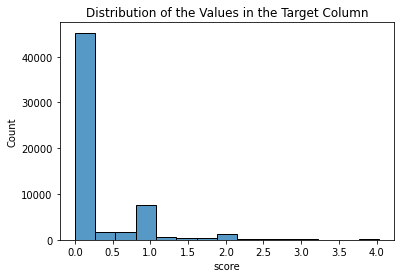

In [ ]:
sns.histplot(train_pa_final['score'], bins=15)
plt.title('Distribution of the Values in the Target Column')
plt.show()

This will be treated as a classification problem with the following categories:

*   'None' (score == 0.0)
*   'Abnormal (D0)' (0.0 < score <= 1.0)
*   'Moderate (D1)' (1.0 < score <= 2.0)
*   'Severe (D2)' (2.0 < score <= 3.0)
*   'Extreme (D3)' (3.0 < score <= 4.0)
*   'Exceptional (D4)' (4.0 < score <= 5.0)

Before updating the classification values, the NaNs in the 'score' columns will need to be imputed. This is due to the fact that the meteorogical data is recorded every day but the drought data is recorded every week.



**Train/Validate/Test**

The split is time-based and was created by the Kaggle dataset author. The split is as follows:

Train: Jan. 1, 2000 to Dec. 31, 2016
Val: Jan. 1, 2017 to Dec. 31, 2018
Test: Jan. 1, 2019 to Dec. 31, 2020

In [ ]:
val = pd.read_csv('/content/validation_timeseries/validation_timeseries.csv')
val.shape

(2268840, 21)

In [ ]:
 # Apply wrangle function to isolate Pennsylvania observations in the validation dataset & add engineered features
val_pa = wrangle(val)

In [ ]:
val_pa_final = pd.merge(left=val_pa, right=soil_pa, how='left', on='fips') # Merge with Soil_PA dataset

In [ ]:
# Set date to DateTime format

val_pa_final['date']= pd.to_datetime(val_pa_final['date'])

In [ ]:
val_pa_final.shape

(48910, 56)

In [ ]:
test = pd.read_csv('/content/test_timeseries/test_timeseries.csv')
test.shape

(2271948, 21)

In [ ]:
# Apply wrangle function to isolate Pennsylvania observations in the test dataset & add engineered features
test_pa = wrangle(test) 

In [ ]:
test_pa_final = pd.merge(left=test_pa, right=soil_pa, how='left', on='fips') # Merge with Soil_PA dataset

In [ ]:
# Set date to DateTime format
test_pa_final['date']= pd.to_datetime(test_pa_final['date'])

In [ ]:
test_pa_final.shape

(48977, 56)

In [ ]:
# Define function to fill the NaNs in the target vector using the interpolate method 
# (with default options for linear interpolation)

def target_interpolate(y):
  y = y.interpolate(inplace = True)

  return y

In [ ]:
target = 'score'
y_train = train_pa_final[target] # Create target vector for training dataset
y_val = val_pa_final[target] # Create target vector for validation dataset
y_test = test_pa_final[target] # Create target vector for test dataset

In [ ]:
target_interpolate(y_train) # Apply target_interpolate function to training dataset

In [ ]:
target_interpolate(y_val) # Apply target_interpolate function to validation dataset
target_interpolate(y_test) # Apply target_interpolate function to test dataset

In [ ]:
# Manually replace first 3 NaN values in y_train (because those values were not interpolated by target_interpolate function)
for i in range(0, 3):
  y_train[i] = y_train[3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Manually replace first 2 NaN values in y_val (because those values were not interpolated by target_interpolate function)
for i in range(0, 2):
  y_val[i] = y_val[2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Set up date as the index
train_pa_final = train_pa_final.set_index('date')
val_pa_final = val_pa_final.set_index('date')
test_pa_final = test_pa_final.set_index('date')

In [ ]:
X_train = train_pa_final.drop(columns = target) # Create feature matrix for training dataset
X_val = val_pa_final.drop(columns = target) # Create feature matrix for validation dataset
X_test = test_pa_final.drop(columns = target) # Create feature matrix for training dataset

# Set up problem as a Classification problem using Random Forest Classifier

In [ ]:
# Function to change target vector float values to drought categories

def drought_cat(y):
  none = (y == 0.0)
  abnormal = (y > 0.0) & (y <= 1.0)
  moderate = (y > 1.0) & (y <= 2.0)
  severe = (y > 2.0) & (y <= 3.0)
  extreme = (y > 3.0) & (y <= 4.0)
  exceptional = (y > 4.0) & (y <= 5.0)

  y.loc[none] = 'none'
  y.loc[abnormal] = 'abnormal'
  y.loc[moderate] = 'moderate'
  y.loc[severe] = 'severe'
  y.loc[extreme] = 'extreme'
  y.loc[exceptional] = 'exceptional'

  return y

In [ ]:
# Apply Drought Category Function to training set target vector

drought_cat(y_train)

0             none
1             none
2             none
3             none
4             none
            ...   
416065    moderate
416066    moderate
416067    moderate
416068    moderate
416069    moderate
Name: score, Length: 416070, dtype: object

In [ ]:
# Apply Drought Category Function to validation set target vector

drought_cat(y_val)

0        moderate
1        moderate
2        moderate
3        moderate
4        moderate
           ...   
48905        none
48906        none
48907        none
48908        none
48909        none
Name: score, Length: 48910, dtype: object

In [ ]:
# Apply Drought Category Function to testing set target vector

drought_cat(y_test)

0            none
1            none
2            none
3            none
4            none
           ...   
48972    abnormal
48973    abnormal
48974    abnormal
48975    abnormal
48976    abnormal
Name: score, Length: 48977, dtype: object

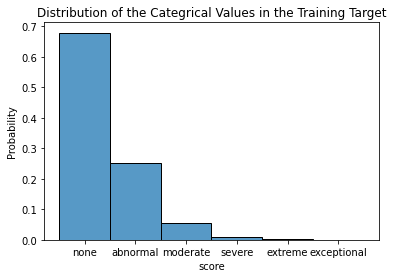

In [ ]:
sns.histplot(y_train, bins=10, stat = 'probability')
plt.title('Distribution of the Categrical Values in the Training Target')
plt.show()


# Evaluation Metric and Baseline Score

**Evaluation metric:**
Because the target vector classes are imbalanced (with 'none' comprising 67%), accuracy_score will not be a good evaluation metric as it could be misleading. 
I plan to rely on balanced_accuracy_score as the evaluation metric and, in addition, plan to plot the confusion matrix and calculate the precision/recall for the different drought categories.

In [ ]:
# Calculate Baseline Score

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)

# Using Accuracy Score on the validation dataset
print(f'Baseline Accuracy of the dummy classifier: '
      f'{dummy_classifier.score(X_val, y_val):.3f}')

# Using Balanced Accuracy on the validation dataset to account for the imbalanced classes
baseline_acc = balanced_accuracy_score(y_val, dummy_classifier.predict(X_val))
print(f'Baseline Balanced Accuracy of the dummy classifier:', baseline_acc)

Baseline Accuracy of the dummy classifier: 0.780
Baseline Balanced Accuracy of the dummy classifier: 0.25


# Random Forest Models with Different Tree Sizes

In [ ]:
# Train Random Forest Classifier with 20 trees
from sklearn.ensemble import RandomForestClassifier

model_20t = RandomForestClassifier(n_jobs = -1, max_depth = 20, random_state = 42)

model_20t.fit(X_train, y_train)

print('Training Balanced Accuracy is:', balanced_accuracy_score(y_train, model_20t.predict(X_train)))
print('Validation Balanced Accuracy is:', balanced_accuracy_score(y_val, model_20t.predict(X_val)))

Training Balanced Accuracy is: 0.8227202049435367
Validation Balanced Accuracy is: 0.27739083249357666


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [ ]:
# Train Random Forest Classifier with class weights
from sklearn.utils.class_weight import compute_class_weight

# Use compute_class_weights() to create numpy array with values for the class weights

weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train
)

# Use zip() to convert numpy array of values for class weights into a dictionary

class_weights = dict(zip(np.unique(y_train), weights))

model_rfw = RandomForestClassifier(
    n_jobs = -1, 
    max_depth = 15, 
    class_weight = class_weights,
    random_state = 42
)

model_rfw.fit(X_train, y_train)

print('Training Balanced Accuracy is:', balanced_accuracy_score(y_train, model_rfw.predict(X_train)))
print('Validation Balanced Accuracy is:', balanced_accuracy_score(y_val, model_rfw.predict(X_val)))

Training Balanced Accuracy is: 0.862555797802082
Validation Balanced Accuracy is: 0.3183607684861218


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


# Random Forest Models with Scalers

In [ ]:
# Train Random Forest Classifier with 15 trees, MinMaxScaler, & Class Weights
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline

pipe_minmax = make_pipeline(
    MinMaxScaler(),
    RandomForestClassifier(n_jobs = -1, 
                           max_depth = 15,
                           class_weight = class_weights,
                           random_state = 42)
)

pipe_minmax.fit(X_train, y_train)

print('Training Balanced Accuracy is:', balanced_accuracy_score(y_train, pipe_minmax.predict(X_train)))
print('Validation Balanced Accuracy is:', balanced_accuracy_score(y_val, pipe_minmax.predict(X_val)))

Training Balanced Accuracy is: 0.8625816677301453
Validation Balanced Accuracy is: 0.31844022244294534


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [ ]:
# Set up Random Forest Classifier with 15 trees, RobustScaler, & Class Weights

pipe_robust = make_pipeline(
    RobustScaler(),
    RandomForestClassifier(n_jobs = -1, 
                           max_depth = 15,
                           class_weight = class_weights,
                           random_state = 42)
)

pipe_robust.fit(X_train, y_train)

print('Training Balanced Accuracy is:', balanced_accuracy_score(y_train, pipe_robust.predict(X_train)))
print('Validation Balanced Accuracy is:', balanced_accuracy_score(y_val, pipe_robust.predict(X_val)))

# RobustScaler < MinMax

Training Balanced Accuracy is: 0.8627473428227828
Validation Balanced Accuracy is: 0.3140504341034744


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [ ]:
# Set up Random Forest Classifier with 15 trees, StandardScaler, & Class Weights

pipe_standard = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_jobs = -1, 
                           max_depth = 15,
                           class_weight = class_weights,
                           random_state = 42)
)

pipe_standard.fit(X_train, y_train)

print('Training Balanced Accuracy is:', balanced_accuracy_score(y_train, pipe_standard.predict(X_train)))
print('Validation Balanced Accuracy is:', balanced_accuracy_score(y_val, pipe_standard.predict(X_val)))

# Standard Scaler > Robust Scaler

Training Balanced Accuracy is: 0.8601971336342208
Validation Balanced Accuracy is: 0.3180822599690373


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


### Conclusion: Scalers Appear to Only Marginally Improve the Balanced Accuracy for the Training and Validation Set when Compared with the Base Random Forest model

# Visualization of Initial Random Forest Model

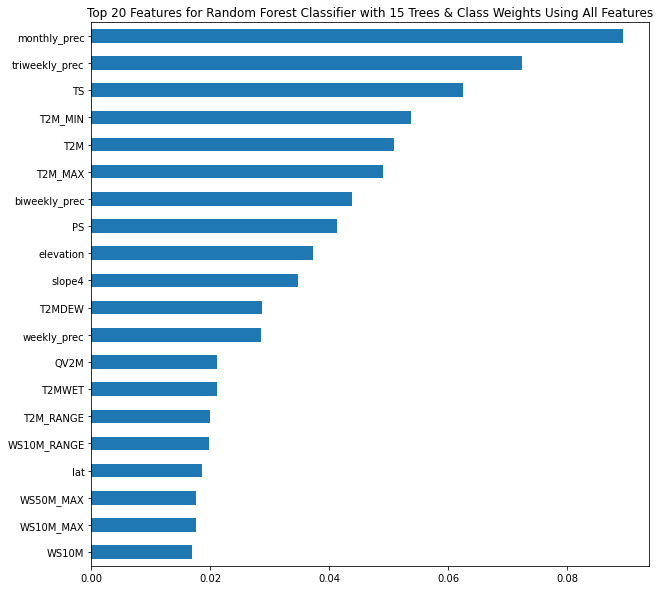

In [ ]:
# Visualize the Top 20 Features of a RF model (15 Trees) & Class Weights

importances = pd.Series(model_rfw.feature_importances_, X_train.columns)

n =20
plt.figure(figsize = (10, n/2))
plt.title(f'Top {n} Features for Random Forest Classifier with 15 Trees & Class Weights Using All Features')
importances.sort_values()[-n:].plot.barh()
plt.show()

# Train Initial XGBoost Model

In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(max_depth = 15,
    objective = 'multi:softmax',
    num_class = 5,
    n_estimators = 100,
    learning_rate = 0.5,
    scale_pos_weight = class_weights,                       
    n_jobs = -1,
    random_state = 42)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, num_class=5, objective='multi:softprob',
              random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight={'abnormal': 0.6606802591463414,
                                'exceptional': 13869.0,
                                'extreme': 44.14067472947168,
                                'moderate': 3.065649867374005,
                                'none': 0.24539084893308327,
                                'severe': 16.03723404255319},
              seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
print('Training Balanced Accuracy for XGBoost Model is:', balanced_accuracy_score(y_train, xgb_model.predict(X_train)))
print('Validation Balanced Accuracy for XGBoost Model is:', balanced_accuracy_score(y_val, xgb_model.predict(X_val)))

Training Balanced Accuracy for XGBoost Model is: 1.0
Validation Balanced Accuracy for XGBoost Model is: 0.2814539613009371


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


# Create Subset of Dataframe to Better Hypertune Parameters

In [ ]:
# Verify Distribution of values in the target vector
y_train.value_counts(normalize = True)

none           0.679189
abnormal       0.252265
moderate       0.054366
severe         0.010392
extreme        0.003776
exceptional    0.000012
Name: score, dtype: float64

In [ ]:
# Create a subset of training dataset to 
train_sm = train_pa_final.sample(n = 100000)
train_sm.shape

(100000, 55)

In [ ]:
X_train_sm = train_sm.drop(target, axis = 1)

In [ ]:
y_train_sm = train_sm[target]

In [ ]:
drought_cat(y_train_sm)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


date
2003-10-18        none
2007-03-11        none
2001-09-11    abnormal
2001-06-01    moderate
2007-02-02        none
                ...   
2013-06-09        none
2013-03-04        none
2009-09-03        none
2010-05-31        none
2004-08-31        none
Name: score, Length: 100000, dtype: object

In [ ]:
# Verify all categories are present in Small Training Set
y_train_sm.value_counts(normalize = True)

none           0.67927
abnormal       0.25248
moderate       0.05456
severe         0.01023
extreme        0.00344
exceptional    0.00002
Name: score, dtype: float64

In [ ]:
# Train Random Forest Classifier on Smaller Training Set

model_rfw_sm = RandomForestClassifier(
    n_jobs = -1,
    max_depth = 10,
    random_state = 42,
    n_estimators = 139,
    min_samples_split = 10,
    class_weight = class_weights,
    bootstrap = False)

model_rfw_sm.fit(X_train_sm, y_train_sm)

print('Training Balanced Accuracy for Small Training Set is:', balanced_accuracy_score(y_train_sm, model_rfw_sm.predict(X_train_sm)))
print('Validation Balanced Accuracy is:', balanced_accuracy_score(y_val, model_rfw_sm.predict(X_val)))

Training Balanced Accuracy for Small Training Set is: 0.7425686671928663
Validation Balanced Accuracy is: 0.33597470735146534


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [ ]:
# Train XGBoost Classifier on Smaller Training Set

model_xgb_sm = XGBClassifier(
    max_depth = 5,
    objective = 'multi:softmax',
    num_class = 5,
    n_estimators = 100,
     learning_rate = 0.5,
    n_jobs = -1,
    scale_pos_weight = class_weights,
    random_state = 42)

model_xgb_sm.fit(X_train_sm, y_train_sm)

print('XGB Training Balanced Accuracy for Small Training Set is:', balanced_accuracy_score(y_train_sm, model_xgb_sm.predict(X_train_sm)))
print('XGB Validation Balanced Accuracy is:', balanced_accuracy_score(y_val, model_xgb_sm.predict(X_val)))

# Apply Hypertuned Parameters from Small Training Dataset to RF Model

In [ ]:
model_rfw_tuned = RandomForestClassifier(
    n_jobs = -1,
    max_depth = 10,
    random_state = 42,
    n_estimators = 139,
    min_samples_split = 10,
    class_weight = class_weights,
    bootstrap = False)

model_rfw_tuned.fit(X_train, y_train)

print('Training Balanced Accuracy for Full Training Set is:', balanced_accuracy_score(y_train, model_rfw_tuned.predict(X_train)))
print('Validation Balanced Accuracy is:', balanced_accuracy_score(y_val, model_rfw_tuned.predict(X_val)))

Training Balanced Accuracy for Full Training Set is: 0.6818217169879267
Validation Balanced Accuracy is: 0.34595707682538346


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


# Apply Hypertuned Parameters from Small Training Dataset to XGB Model

In [ ]:
xgb_tuned = XGBClassifier(
    max_depth = 5,
    objective = 'multi:softmax',
    num_class = 5,
    n_estimators = 100,
    learning_rate = 0.5,
    scale_pos_weight = class_weights, 
    n_jobs = -1,
    random_state = 42)

xgb_tuned.fit(X_train_sm, y_train_sm)

print('XGB Training Balanced Accuracy is:', balanced_accuracy_score(y_train, xgb_tuned.predict(X_train)))
print('XGB Validation Balanced Accuracy is:', balanced_accuracy_score(y_val, xgb_tuned.predict(X_val)))

XGB Training Balanced Accuracy is: 0.47472701272498924
XGB Validation Balanced Accuracy is: 0.28741263898159053


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


# Conclusion: Random Forest Model Produces Better Results Than XGBoost Model

# Use SelectKBest to Find the Best Features in the Best Model

In [ ]:
# SelectKBest for Full Dataset
from sklearn.feature_selection import SelectKBest, f_classif

df = pd.DataFrame(columns = ['No. Features', 'Bal Acc Train', 'Bal Acc Val'])

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)

    model = model_rfw_tuned
    
    model.fit(X_train_selected, y_train)
    
    # Calculate the Training Balanced_Accuracy for Each k Features in Loop
    y_pred_train = model.predict(X_train_selected)
    bal_acc_train = balanced_accuracy_score(y_train, y_pred_train) 
    
    # Calculate the Validation Balanced_Accuracy for Each k Features in Loop
    y_pred_val = model.predict(X_val_selected)
    bal_acc_val = balanced_accuracy_score(y_val, y_pred_val)
    
    print(f'Training Balanced Accuracy is: {bal_acc_train} \n')
    print(f'Validation Balanced Accuracy is: {bal_acc_val} \n')
     
    df = df.append({'No. Features' : k, 'Bal Acc Train' : bal_acc_train, 
                    'Bal Acc Val' : bal_acc_val},  ignore_index = True)

1 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.49013694787323364 

Validation Balanced Accuracy is: 0.3152247453627539 

2 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.5571613183969476 

Validation Balanced Accuracy is: 0.3015238744987553 

3 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.5871520087656249 

Validation Balanced Accuracy is: 0.31753679303561616 

4 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6211339770204515 

Validation Balanced Accuracy is: 0.2791070673131206 

5 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6230478519263984 

Validation Balanced Accuracy is: 0.2663798403047414 

6 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6188601759591243 

Validation Balanced Accuracy is: 0.2676463117908867 

7 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6312695864213305 

Validation Balanced Accuracy is: 0.25796675918175094 

8 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6280682065557749 

Validation Balanced Accuracy is: 0.24982911518428386 

9 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6597441963842456 

Validation Balanced Accuracy is: 0.2580630154466233 

10 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6750699759625234 

Validation Balanced Accuracy is: 0.25590148004734403 

11 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6754944324591761 

Validation Balanced Accuracy is: 0.26249380345430623 

12 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.674655207036955 

Validation Balanced Accuracy is: 0.2694545523123233 

13 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6767465715962202 

Validation Balanced Accuracy is: 0.27400206189454096 

14 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6772271508818776 

Validation Balanced Accuracy is: 0.27863541965758165 

15 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6833597905207754 

Validation Balanced Accuracy is: 0.2984462090352351 

16 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6925904698172779 

Validation Balanced Accuracy is: 0.3155818145930989 

17 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6897434220763635 

Validation Balanced Accuracy is: 0.32778252709143574 

18 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6900450658883189 

Validation Balanced Accuracy is: 0.3236595145812928 

19 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6929036731584058 

Validation Balanced Accuracy is: 0.3167172034016604 

20 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.688387879620925 

Validation Balanced Accuracy is: 0.31043033646426454 

21 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6874829578551126 

Validation Balanced Accuracy is: 0.31481457682786496 

22 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6870165516465504 

Validation Balanced Accuracy is: 0.32412285669095553 

23 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6855507909058914 

Validation Balanced Accuracy is: 0.3133110199982072 

24 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6847136367387717 

Validation Balanced Accuracy is: 0.3142002534234441 

25 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6896074192059597 

Validation Balanced Accuracy is: 0.3260496387089324 

26 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6887132452193651 

Validation Balanced Accuracy is: 0.33395784810337986 

27 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.688942530745902 

Validation Balanced Accuracy is: 0.3369701626392845 

28 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6870063154952769 

Validation Balanced Accuracy is: 0.3289296357448761 

29 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6885540174533823 

Validation Balanced Accuracy is: 0.3362729929568472 

30 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6860635529478526 

Validation Balanced Accuracy is: 0.3318779572729621 

31 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6859746172242852 

Validation Balanced Accuracy is: 0.33827212679764374 

32 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6839443611848083 

Validation Balanced Accuracy is: 0.32984792483719616 

33 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6862393194956894 

Validation Balanced Accuracy is: 0.32620223574263124 

34 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6841737002645099 

Validation Balanced Accuracy is: 0.3323194261124218 

35 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6838342215943639 

Validation Balanced Accuracy is: 0.3372156220227875 

36 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6859728961651809 

Validation Balanced Accuracy is: 0.3311859816936451 

37 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6859970462388727 

Validation Balanced Accuracy is: 0.3294256485490447 

38 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6860760204609547 

Validation Balanced Accuracy is: 0.3306591205031052 

39 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6843917128719981 

Validation Balanced Accuracy is: 0.3345306288442594 

40 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.684394135223605 

Validation Balanced Accuracy is: 0.3283448700023469 

41 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6816311190953802 

Validation Balanced Accuracy is: 0.3311589575909473 

42 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6817665250524972 

Validation Balanced Accuracy is: 0.331981817920927 

43 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6834786835368489 

Validation Balanced Accuracy is: 0.3266596459493951 

44 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6827403327855875 

Validation Balanced Accuracy is: 0.33505398824120225 

45 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6797024969720992 

Validation Balanced Accuracy is: 0.3408727030795784 

46 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6824070607410988 

Validation Balanced Accuracy is: 0.34153976876215686 

47 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6820689092438252 

Validation Balanced Accuracy is: 0.3365453467694271 

48 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6814314494290552 

Validation Balanced Accuracy is: 0.336450034720223 

49 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6851529894974311 

Validation Balanced Accuracy is: 0.3319816051853657 

50 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6825882674925173 

Validation Balanced Accuracy is: 0.33543687747201056 

51 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6821915573369194 

Validation Balanced Accuracy is: 0.3396072886113609 

52 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6817040034243895 

Validation Balanced Accuracy is: 0.33410575006519905 

53 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Training Balanced Accuracy is: 0.6838487024012746 

Validation Balanced Accuracy is: 0.34120598485433556 

54 features


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [40 49 51 52 53] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Training Balanced Accuracy is: 0.6818217169879267 

Validation Balanced Accuracy is: 0.34595707682538346 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [ ]:
# Order the Dataframe by the Highest Baseline Accuracy for the Validation
# dataset to Determine the Number of Features to Include in Final Model 

df['Bal Acc Val'].sort_values(ascending = False)

53    0.345957
45    0.341540
52    0.341206
44    0.340873
50    0.339607
30    0.338272
34    0.337216
26    0.336970
46    0.336545
47    0.336450
28    0.336273
49    0.335437
43    0.335054
38    0.334531
51    0.334106
25    0.333958
33    0.332319
41    0.331982
48    0.331982
29    0.331878
35    0.331186
40    0.331159
37    0.330659
31    0.329848
36    0.329426
27    0.328930
39    0.328345
16    0.327783
42    0.326660
32    0.326202
24    0.326050
21    0.324123
17    0.323660
2     0.317537
18    0.316717
15    0.315582
0     0.315225
20    0.314815
23    0.314200
22    0.313311
19    0.310430
1     0.301524
14    0.298446
3     0.279107
13    0.278635
12    0.274002
11    0.269455
5     0.267646
4     0.266380
10    0.262494
8     0.258063
6     0.257967
9     0.255901
7     0.249829
Name: Bal Acc Val, dtype: float64

# Conclusion: The highest Balanced Accuracy on the Validation dataset included all of the features in the Hypertined Random Forest Model

# Test Balance Accuracy under Final Hypertuned Random Forest Model

In [ ]:
bal_acc_test_final = balanced_accuracy_score(y_test, model_rfw_tuned.predict(X_test))

print(f'Test Balanced Accuracy for Final Model is: {bal_acc_test_final} \n')

Test Balanced Accuracy for Final Model is: 0.2985107597791204 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


# Visualization of the Features of the Final Hypertuned Random Forest Model

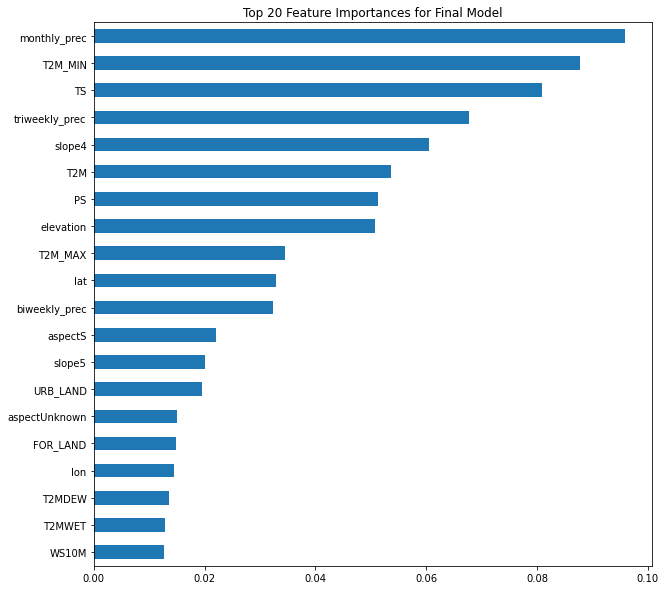

In [ ]:
importances_final = pd.Series(model_rfw_tuned.feature_importances_, X_train.columns)

n = 20
plt.figure(figsize = (10, n/2))
plt.title(f'Top {n} Feature Importances for Final Model')
importances_final.sort_values()[-n:].plot.barh()
plt.show()

# Confusion Matrix, Classification Report

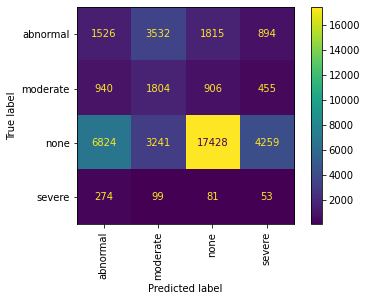

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model_rfw_tuned, X_test, y_test, values_format = '.0f', 
                      xticks_rotation = 'vertical', 
                      labels = ['abnormal', 'moderate', 'none', 'severe'])
plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_pred_final = model_rfw_tuned.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_final))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    abnormal       0.16      0.18      0.17      8350
 exceptional       0.00      0.00      0.00         0
     extreme       0.00      0.00      0.00         0
    moderate       0.21      0.42      0.28      4292
        none       0.86      0.49      0.62     35828
      severe       0.01      0.10      0.02       507

    accuracy                           0.42     48977
   macro avg       0.21      0.20      0.18     48977
weighted avg       0.68      0.42      0.51     48977

